# NumpyNet: Neural Network using only NumPy

In [1]:
# Import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np



## Load Data

In [2]:
(X_train, Y_train),(X_test, Y_test) = tf.keras.datasets.mnist.load_data()

## Preprocess data

In [3]:
#def normalize(x):
 #   return (x - np.min(x)) / (np.max(x) - np.min(x))

# Preprocessing image data
train_images = X_train.reshape((60000, 28*28)).T # reshape to feed into network
train_images = train_images.astype('float32') / 255 # normalize
#train_images = normalize(train_images)


test_images = X_test.reshape((10000, 28 * 28)).T # reshape to feed into network
test_images = test_images.astype('float32') / 225 # normalize
#test_images = normalize(test_images)

print("Shape of train_images: {}".format(train_images.shape))

Shape of train_images: (784, 60000)


In [4]:
# preprocess label data

# one hot encode the labels of shape (num examples, 1)
def one_hot(labels):
    # create matrix of correct sizing with zeros
    oh_labels = np.zeros((labels.size, labels.max() + 1))
    # specify for each row to place a 1 in the column corresponding to the correct label
    # i.e. if label = 2 ; [0 0 1 0 0 0 0 0 0 0]
    oh_labels[np.arange(labels.size), labels] = 1
    # flip so each column is an example
    oh_labels = oh_labels.T
    
    return oh_labels

train_labels = one_hot(Y_train)
test_labels = one_hot(Y_test)

print("Shape of train_labels: {}".format(train_labels.shape))

Shape of train_labels: (10, 60000)


## Initialize Parameters

In [5]:
def initialize_params(seed):
    np.random.seed(seed)
    W1 = np.random.randn(64, 784) * np.sqrt(2./784)
    b1 = np.zeros((64, 1))
    W2 = np.random.randn(10, 64) * np.sqrt(2./64)
    b2 = np.zeros((10, 1))
   
    return W1, b1, W2, b2


## Activation Functions

In [6]:
# ReLU for hidden layers
def ReLU(Z):
    return np.maximum(Z, 0)

# for backprop through hidden layers
def ReLU_deriv(Z):
    return Z > 0

# Softmax for output layer
def softmax(Z):
    A = np.exp(Z)/ sum(np.exp(Z))
    return A

## Forward Propagation

In [7]:
def forward_prop(X, Y, W1, b1, W2, b2):
    m = X.shape[1]
    Z1 = np.dot(W1, X) + b1
    A1 = ReLU(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2) # make predictions
    
    cost = (-1/m) * np.sum(Y * np.log(A2+1e-9))

    return Z1, A1, Z2, A2, cost

## Back Propagation

In [8]:
def back_prop(X, Y, Z1, A1, Z2, A2, W1, W2): # Z2, W1 not needed
    # total sample count
    m = X.shape[1]

    # layer 2
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # layer 1
    dZ1 = np.dot(W2.T, dZ2) * ReLU_deriv(Z1)
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2

## Update Parameters

In [9]:
def update_parameters(W1, b1, W2, b2, dW1, dW2, db1, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2

    return W1, b1, W2, b2

## Evaluation functions

In [10]:
def get_labels(A2):
    return np.argmax(A2, axis=0)

def get_accuracy(A2, Y):
    return np.mean(A2.argmax(axis=0) == Y.argmax(axis=0))


## Model

In [11]:
def nn(X, Y, alpha, iterations, seed=33):
    W1, b1, W2, b2 = initialize_params(seed)
    # loop through gradient descent based on the number of iterations and add accuracy to empty list
    acc = []
    costs = []
    for i in range(iterations):
        # forward prop
        Z1, A1, Z2, A2, cost = forward_prop(X, Y, W1, b1, W2, b2)
        costs.append(cost)
        # back prop
        dW1, db1, dW2, db2 = back_prop(X, Y, Z1, A1, Z2, A2, W1, W2)
        # update parameters
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, dW2, db1, db2, alpha)
        # display accuracy and predictions every 10 iterations of gradient descent
        if i % 100 == 0:
            predictions = get_labels(A2)
            accuracy = get_accuracy(A2, Y)
            acc.append(accuracy)
            print("Iteration: {} | Accuracy: {:.3f}% | Loss:{:.3f}".format(i, accuracy*100, costs[i]))
            
        
    return W1, b1, W2, b2, acc, costs

## Train Model

Iteration: 0 | Accuracy: 13.878% | Loss:2.426
Iteration: 100 | Accuracy: 87.897% | Loss:0.467
Iteration: 200 | Accuracy: 89.910% | Loss:0.367
Iteration: 300 | Accuracy: 90.827% | Loss:0.327
Iteration: 400 | Accuracy: 91.552% | Loss:0.302


Text(0.5, 1.0, 'training loss')

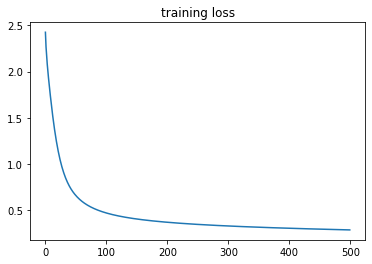

In [12]:

W1, b1, W2, b2, accuracy, costs = nn(train_images, train_labels, 0.1, 500)

# plot training loss
loss = np.array(costs)
x = [x for x in range(len(loss))]
plt.plot(x, loss)
plt.title("training loss")


Text(0.5, 1.0, 'training accuracy')

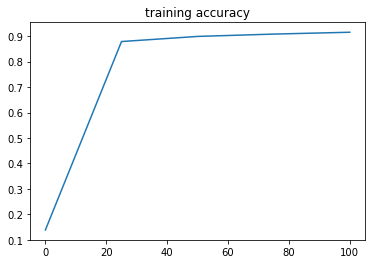

In [13]:

# plot training accuracy
acc = np.array(accuracy)
x = [x * 25 for x in range(len(acc))]
plt.plot(x, acc)

plt.title("training accuracy")


## Test model params

In [14]:
def nn_eval(X, Y, W1, b1, W2, b2):
    # forward pass with the weights from trained model
    Z1, A1, Z2, A2, loss = forward_prop(X, Y, W1, b1, W2, b2)
    preds = get_labels(A2)
    acc = get_accuracy(A2, Y)
   
    return preds, acc

In [15]:
pred_labels, accuracy = nn_eval(test_images, test_labels, W1, b1, W2, b2)
print("Accuracy: {:.2f} %".format(accuracy*100))

Accuracy: 92.18 %
